In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from collections import defaultdict
from pathlib import Path

import torch

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

## Check performance against Interpro2GO

In [3]:
data_dir = Path("/weka/scratch/weka/kellislab/rcalef/data/magneton-data/evaluations/GeneOntology/")

path = data_dir / "interpro2go.txt"

go_to_interpro = defaultdict(list)
with open(path) as fh:
    for line in fh:
        if line.startswith("!"):
            continue
        interpro_id = line.split()[0].split(":")[-1]
        go_id = line.split(";")[-1].strip()
        go_to_interpro[go_id].append(interpro_id)


In [4]:
label_fname = data_dir / "nrPDB-GO_annot.tsv"
label_line = 1
with open(label_fname, "r") as f:
    all_labels = f.readlines()[label_line].strip("\n").split("\t")
labeller = LabelEncoder().fit(all_labels)
num_classes = len(labeller.classes_)

In [5]:
run_path = "/weka/scratch/weka/kellislab/rcalef/projects/magneton/experiments/downstream_evals/deepfri_prosst_orig/GO:MF/test_results.pt"
results = torch.load(run_path)

In [6]:
def get_per_label_fmax(
    run_path: Path,
) -> pd.DataFrame:
    results = torch.load(run_path)
    logits = results["logits"]
    labels = results["labels"]
    num_thresh_steps=101

    probs = logits.sigmoid()
    f1s = []
    thresh_vals = torch.linspace(start=0, end=1, steps=num_thresh_steps)
    for thresh in thresh_vals:
        preds = probs >= thresh

        tp = ((preds == labels) & labels).sum()
        fp = ((preds != labels) & labels).sum()
        tn = ((preds == labels) & ~labels).sum()
        fn = ((preds != labels) & ~labels).sum()

        f1 = (2*tp) / (2*tp + fp + fn)
        f1s.append(f1)

    f1s = torch.stack(f1s)
    fmax = f1s.max()
    best_thresh = thresh_vals[f1s.argmax()].item()
    print(fmax, best_thresh)

    preds = probs >= best_thresh

    tp = ((preds == labels) & labels).sum(dim=0)
    fp = ((preds != labels) & labels).sum(dim=0)
    fn = ((preds != labels) & ~labels).sum(dim=0)

    per_label_fmax = (2*tp) / (2*tp + fp + fn)

    return pd.DataFrame({
        "go_id": labeller.classes_.tolist(),
        "fmax": per_label_fmax.tolist(),
    })

In [7]:
got = get_per_label_fmax(run_path)
got.head()

tensor(0.6309) 0.05999999865889549


,go_id,fmax
0,GO:0000049,0.270270
1,GO:0000287,0.466019
2,GO:0000976,0.000000
3,GO:0000977,0.000000
4,GO:0000981,0.142857


In [8]:
orig_label_fmax = get_per_label_fmax("/weka/scratch/weka/kellislab/rcalef/projects/magneton/experiments/downstream_evals/deepfri_prosst_orig/no_ft/GO:MF/test_results.pt")
dom_label_fmax = get_per_label_fmax("/weka/scratch/weka/kellislab/rcalef/projects/magneton/experiments/downstream_evals/deepfri_prosst_domain_default_lr/no_ft/GO:MF/test_results.pt")

tensor(0.5391) 0.17999999225139618
tensor(0.5816) 0.23999999463558197


In [9]:
combined = (
    orig_label_fmax
    .merge(
        dom_label_fmax,
        on="go_id",
        suffixes=("_orig", "_dom")
    )
    .assign(
        fmax_diff=lambda x: x.fmax_dom - x.fmax_orig,
        fmax_pct_change=lambda x: (x.fmax_diff / x.fmax_orig)*100,
    )
    .loc[lambda x: ~x.fmax_orig.isna()]
)
combined.head()

,go_id,fmax_orig,fmax_dom,fmax_diff,fmax_pct_change
0,GO:0000049,0.108108,0.263158,0.155050,143.421055
1,GO:0000287,0.312500,0.407767,0.095267,30.485439
2,GO:0000976,0.000000,0.000000,0.000000,NaN
3,GO:0000977,0.000000,0.000000,0.000000,NaN
4,GO:0000981,0.133333,0.210526,0.077193,57.894730


<Axes: >

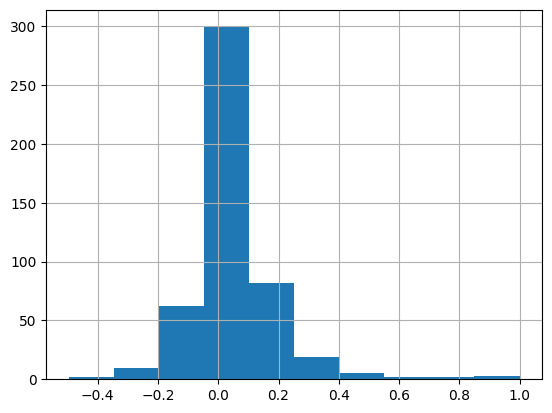

In [10]:
combined.fmax_diff.hist()

In [11]:
train_counts = pd.read_table("/weka/scratch/weka/kellislab/rcalef/data/magneton-data/interpro_103.0/dataset_splits/seq_splits_stats/train/Domain_summaries.tsv")
train_counts.head()

,element_id,element_name,count,max_occurences,min_len,max_len,avg_len,min_num_segs,max_num_segs,avg_num_segs,avg_coverage
0,IPR000001,Kringle,70,1,76.0,810.0,144.114286,1.0,10.0,1.771429,0.249973
1,IPR000007,"Tubby, C-terminal",41,1,53.0,340.0,253.585366,1.0,1.0,1.000000,0.583689
2,IPR000008,C2 domain,209,1,92.0,889.0,189.626794,1.0,7.0,1.502392,0.246526
3,IPR000010,Cystatin domain,135,1,31.0,713.0,124.392593,1.0,8.0,1.222222,0.771733
4,IPR000014,PAS domain,246,3,30.0,448.0,115.451220,1.0,4.0,1.369919,0.157227


In [12]:
test_counts = pd.read_table("/weka/scratch/weka/kellislab/rcalef/data/magneton-data/interpro_103.0/dataset_splits/seq_splits_stats/test/Domain_summaries.tsv")
test_counts.head()

,element_id,element_name,count,max_occurences,min_len,max_len,avg_len,min_num_segs,max_num_segs,avg_num_segs,avg_coverage
0,IPR000001,Kringle,12,1,76.0,408.0,270.083333,1.0,5.0,3.333333,0.339999
1,IPR000007,"Tubby, C-terminal",3,1,242.0,322.0,282.333333,1.0,1.0,1.000000,0.637214
2,IPR000008,C2 domain,24,1,102.0,774.0,192.916667,1.0,6.0,1.500000,0.303164
3,IPR000010,Cystatin domain,18,1,88.0,325.0,150.444444,1.0,3.0,1.444444,0.726075
4,IPR000014,PAS domain,54,1,48.0,468.0,117.537037,1.0,4.0,1.388889,0.178130


In [13]:
def count_train_num(go_id: str) -> int:
    interpro_ids = pd.Series(go_to_interpro[go_id])

    want_rows = train_counts.loc[lambda x: x.element_id.isin(interpro_ids)]
    if len(want_rows) == 0:
        return 0
    return want_rows["count"].sum()

def count_test_num(go_id: str) -> int:
    interpro_ids = pd.Series(go_to_interpro[go_id])

    want_rows = test_counts.loc[lambda x: x.element_id.isin(interpro_ids)]
    if len(want_rows) == 0:
        return 0
    return want_rows["count"].sum()

In [14]:
count_train_num("GO:0003677")

9171

In [15]:
combined = (
    combined
    .assign(
        train_count=lambda x: x.go_id.apply(count_train_num),
        test_count=lambda x: x.go_id.apply(count_test_num),
    )
)
combined.head()

,go_id,fmax_orig,fmax_dom,fmax_diff,fmax_pct_change,train_count,test_count
0,GO:0000049,0.108108,0.263158,0.155050,143.421055,1105,274
1,GO:0000287,0.312500,0.407767,0.095267,30.485439,1377,127
2,GO:0000976,0.000000,0.000000,0.000000,NaN,67,3
3,GO:0000977,0.000000,0.000000,0.000000,NaN,148,6
4,GO:0000981,0.133333,0.210526,0.077193,57.894730,378,35


In [16]:
import numpy as np

In [17]:
np.average(a=combined.fmax_dom.values, weights=combined.test_count.values)

0.6575520264297845

In [18]:
np.average(a=combined.fmax_orig.values, weights=combined.test_count.values)

0.6033546854878734

<Axes: xlabel='train_count', ylabel='fmax_diff'>

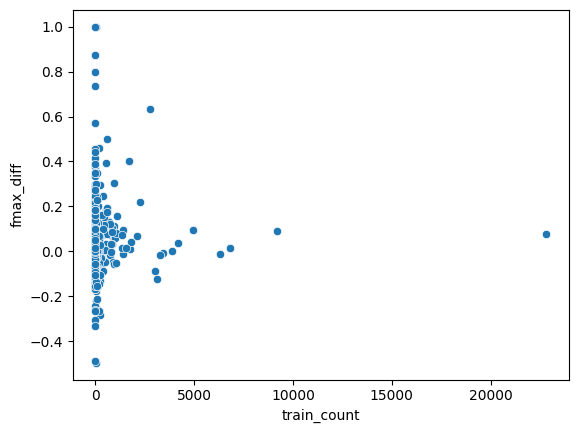

In [19]:
sns.scatterplot(x="train_count", y="fmax_diff", data=combined)
#plt.xscale("log")

In [20]:
combined.train_count.describe()

count      486.000000
mean       266.049383
std       1293.738319
min          0.000000
25%          0.000000
50%          0.000000
75%         73.250000
max      22819.000000
Name: train_count, dtype: float64

Text(0.5, 1.0, 'GO:MF prediction improvement not trivially explained by InterPro2GO mapping')

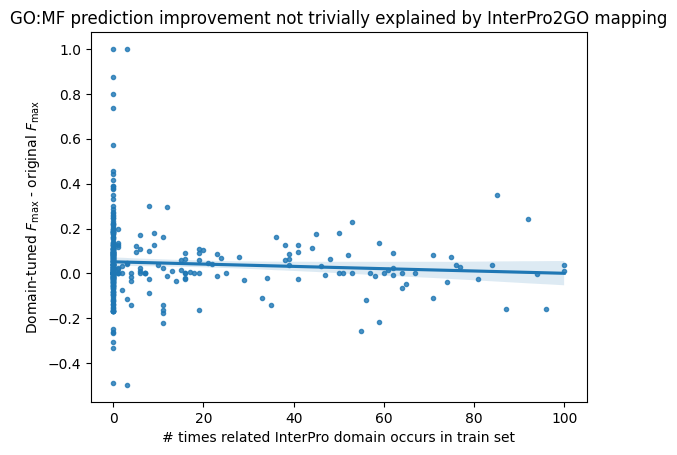

In [21]:
sns.regplot(
    x="train_count",
    y="fmax_diff",
    marker=".",
    data=combined.query("train_count <= 100"),
)
plt.ylabel("Domain-tuned $F_{\max}$ - original $F_{\max}$")
plt.xlabel("# times related InterPro domain occurs in train set")
plt.title("GO:MF prediction improvement not trivially explained by InterPro2GO mapping")
#plt.xscale("log")

Text(0.5, 1.0, 'GO:MF prediction improvement not trivially explained by InterPro2GO mapping')

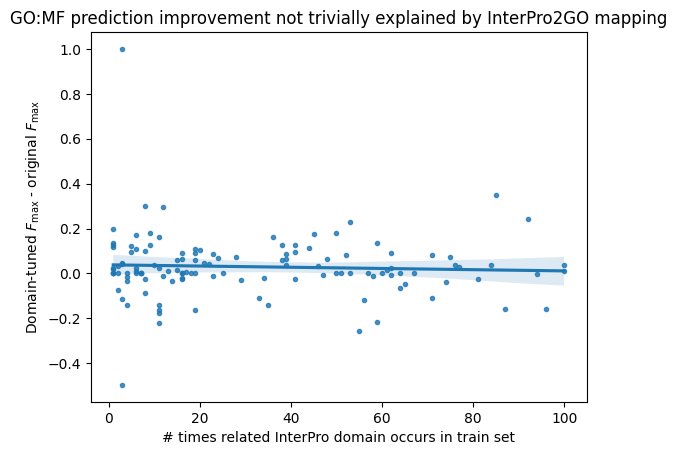

In [22]:
sns.regplot(
    x="train_count",
    y="fmax_diff",
    marker=".",
    data=combined.query("train_count <= 100 and train_count > 0"),
)
plt.ylabel("Domain-tuned $F_{\max}$ - original $F_{\max}$")
plt.xlabel("# times related InterPro domain occurs in train set")
plt.title("GO:MF prediction improvement not trivially explained by InterPro2GO mapping")
#plt.xscale("log")

In [23]:
combined

,go_id,fmax_orig,fmax_dom,fmax_diff,fmax_pct_change,train_count,test_count
0,GO:0000049,0.108108,0.263158,0.155050,143.421055,1105,274
1,GO:0000287,0.312500,0.407767,0.095267,30.485439,1377,127
2,GO:0000976,0.000000,0.000000,0.000000,NaN,67,3
3,GO:0000977,0.000000,0.000000,0.000000,NaN,148,6
4,GO:0000981,0.133333,0.210526,0.077193,57.894730,378,35
...,...,...,...,...,...,...,...
484,GO:0140375,0.000000,0.571429,0.571429,inf,0,0
485,GO:1901681,0.166667,0.161616,-0.005051,-3.030306,0,0
486,GO:1901982,0.000000,0.000000,0.000000,NaN,0,0
487,GO:1904680,0.500000,0.550000,0.050000,10.000002,0,0


In [24]:
plot_data = (
    combined
    .query("train_count <= 100 and train_count > 0")
    .loc[lambda x: ~x.fmax_pct_change.isna()]
)
plot_data.head()

,go_id,fmax_orig,fmax_dom,fmax_diff,fmax_pct_change,train_count,test_count
7,GO:0001882,0.835443,0.844262,0.008819,1.055641,6,0
11,GO:0003678,0.434783,0.461538,0.026756,6.153850,77,5
12,GO:0003682,0.000000,0.065934,0.065934,inf,39,1
14,GO:0003690,0.027397,0.027211,-0.000186,-0.680273,1,0
15,GO:0003697,0.294118,0.178571,-0.115546,-39.285715,3,1


In [26]:
import matplotlib.ticker as ticker


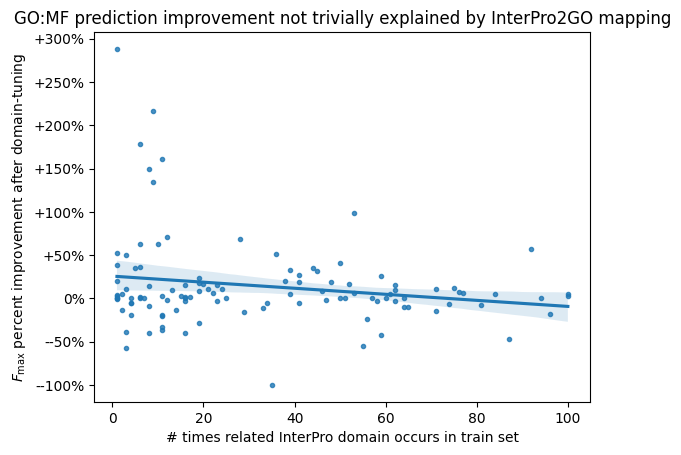

In [27]:
ax = sns.regplot(
    x="train_count",
    y="fmax_pct_change",
    marker=".",
    data=(
        combined
        .query("train_count <= 100 and train_count > 0")
        .loc[lambda x: ~x.fmax_pct_change.isna() & ~np.isinf(x.fmax_pct_change)]
    ),
)
plt.ylabel("$F_{\max}$ percent improvement after domain-tuning")
plt.xlabel("# times related InterPro domain occurs in train set")
plt.title("GO:MF prediction improvement not trivially explained by InterPro2GO mapping")

def fmt_func(x, pos):
    'The two args are the value and tick position'
    if x == 0:
        return "0%"
    if x < 0:
        return f"-{int(x)}%"
    if x > 0:
        return f"+{int(x)}%"

formatter = ticker.FuncFormatter(fmt_func)

ax.yaxis.set_major_formatter(formatter)

#plt.xscale("log")

In [28]:
combined = (
    combined
    .assign(
        in_train=lambda x: x.train_count != 0,
    )
)
combined.head()

,go_id,fmax_orig,fmax_dom,fmax_diff,fmax_pct_change,train_count,test_count,in_train
0,GO:0000049,0.108108,0.263158,0.155050,143.421055,1105,274,True
1,GO:0000287,0.312500,0.407767,0.095267,30.485439,1377,127,True
2,GO:0000976,0.000000,0.000000,0.000000,NaN,67,3,True
3,GO:0000977,0.000000,0.000000,0.000000,NaN,148,6,True
4,GO:0000981,0.133333,0.210526,0.077193,57.894730,378,35,True


Text(0.5, 1.0, 'GO:MF prediction improvement not trivially explained by InterPro2GO mapping')

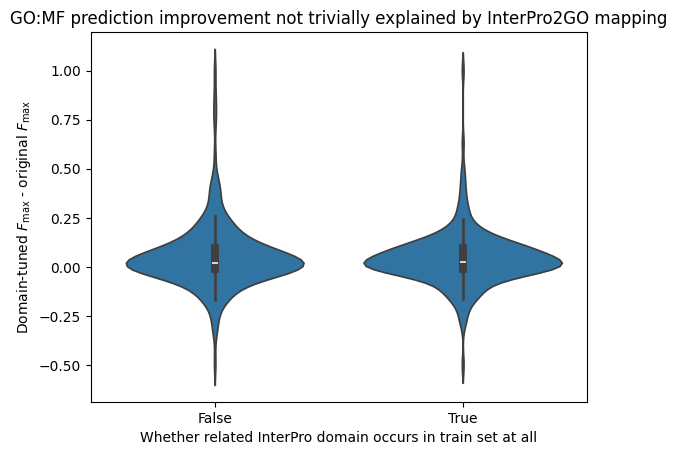

In [29]:
sns.violinplot(
    x="in_train",
    y="fmax_diff",
    data=combined,
)
plt.ylabel("Domain-tuned $F_{\max}$ - original $F_{\max}$")
plt.xlabel("Whether related InterPro domain occurs in train set at all")
plt.title("GO:MF prediction improvement not trivially explained by InterPro2GO mapping")

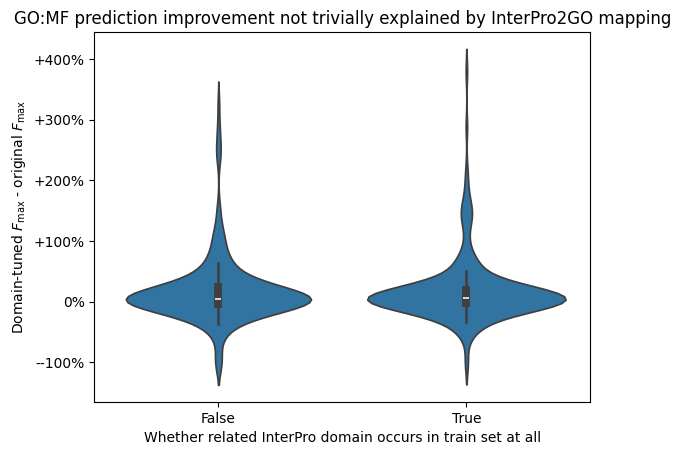

In [30]:
ax = sns.violinplot(
    x="in_train",
    y="fmax_pct_change",
    data=combined,
)
plt.ylabel("Domain-tuned $F_{\max}$ - original $F_{\max}$")
plt.xlabel("Whether related InterPro domain occurs in train set at all")
plt.title("GO:MF prediction improvement not trivially explained by InterPro2GO mapping")

formatter = ticker.FuncFormatter(fmt_func)
ax.yaxis.set_major_formatter(formatter)


In [36]:
(
    combined
    .loc[lambda x: ~x.fmax_pct_change.isna()]
    .loc[lambda x: ~np.isinf(x.fmax_pct_change)]
    .groupby("in_train").fmax_pct_change.describe()
)

,count,mean,std,min,25%,50%,75%,max
in_train,,,,,,,,
False,228.0,16.840643,55.738807,-100.0,-3.405266,4.880953,23.35345,325.308619
True,215.0,17.821464,53.862619,-100.0,-2.361113,5.109146,18.66065,379.999993


In [31]:
combined.groupby("in_train").fmax_pct_change.describe()

/net/vast-storage/scratch/vast/kellislab/rcalef/sandbox/repos/magneton/.venv/lib/python3.11/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/net/vast-storage/scratch/vast/kellislab/rcalef/sandbox/repos/magneton/.venv/lib/python3.11/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,count,mean,std,min,25%,50%,75%,max
in_train,,,,,,,,
False,238.0,inf,NaN,-100.0,-3.030305,5.593420,29.838305,inf
True,225.0,inf,NaN,-100.0,-1.805557,5.882353,24.137931,inf


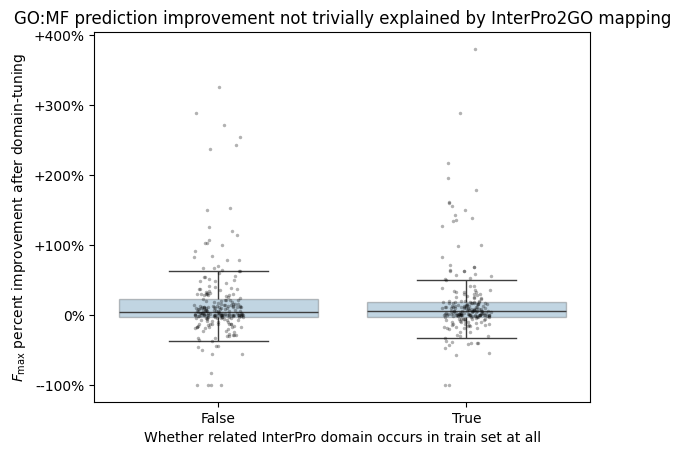

In [ ]:
ax = sns.boxplot(
    x="in_train",
    y="fmax_pct_change",
    data=combined,
    boxprops=dict(alpha=.3),
    fliersize=False,
)
sns.stripplot(
    x="in_train",
    y="fmax_pct_change",
    data=combined,
    ax=ax,
    color="black",
    alpha=0.3,
    marker=".",
)
plt.ylabel("$F_{\max}$ percent improvement after domain-tuning")
plt.xlabel("Whether related InterPro domain occurs in train set at all")
plt.title("GO:MF prediction improvement not trivially explained by InterPro2GO mapping")

formatter = ticker.FuncFormatter(fmt_func)
ax.yaxis.set_major_formatter(formatter)


In [ ]:
combined.groupby("in_train").fmax_diff.describe()

,count,mean,std,min,25%,50%,75%,max
in_train,,,,,,,,
False,252.0,0.054736,0.166485,-0.490255,-0.011977,0.020894,0.097402,1.0
True,234.0,0.043385,0.138536,-0.496684,-0.007910,0.024568,0.094758,1.0
